In [1]:
# mount the drive for latter importing the datasets
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#**1. Import dictionaries**

In [2]:
# download nltk and the stopwords
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# download the rest of dictionaries
from collections import defaultdict
from array import array
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import math
import numpy as np
import collections
from numpy import linalg as la
import time

#new dictionaries for this lab
import pandas as pd
from gensim.models.word2vec import Word2Vec
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# We have added these dictionaries to the ones that were included in lab 1
import json
import re
import csv

#**2. Load the datasets**

In [4]:
docs_path = 'drive/MyDrive/IRWA/Part_1:Text_Processing/Hurricane_Ian_Corpus/data/tw_hurricane_data.json'
tweets = []
# open the JSON file
with open(docs_path) as fp:
    for jsonObj in fp:
        tweetsDict = json.loads(jsonObj)
        tweets.append(tweetsDict) # add the tweets in our array tweets

In [5]:
docs_path_2 = 'drive/MyDrive/IRWA/Part_1:Text_Processing/Hurricane_Ian_Corpus/data/tweet_document_ids_map.csv'
doc_id = {}
# open the CSV file
with open(docs_path_2, newline='') as csvfile:
  spamreader = csv.reader(csvfile, delimiter=' ', quotechar=' ')
  for row in spamreader:
    doc_id[row[0].split()[1]] = row[0].split()[0] # add the doc number as an entry of our dictionary, having the tweet id as the key of this entry

#**3. Text Processing**

In [6]:
def build_terms(tweet):
    """
    Preprocess the text of the tweet by eliminating the url, the people labelled with the @,
    eliminating the punctuation, separating the words after the hashtag, removing stop words, 
    stemming, transforming in lowercase and returning the tokens of the text.
    
    Argument:
    tweet -- string (text) to be pre-processed
    
    Returns:
    tweet - a list of tokens corresponding to the input text after the pre-processing
    """

    stemmer = PorterStemmer() # stemm the words to get the root of the word and avoid having different words that mean the same
    stop_words = set(stopwords.words("english")) # eliminate all the stop words to make efficient queries and documents
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+') # separate the words without including puntuation marks
    
    tweet = re.sub(r'http\S+', '', tweet) ## delete the url
    tweet = re.sub(r'@\S+', '', tweet) ## delete the word after @ (so the people labelled)
    tweet = " ".join([a for a in re.split('([A-Z][a-z]+)', tweet) if a]) ## separate the hashtags in words according to the capital letters
    tweet = tweet.replace("_", " ") ## eliminate the _ (it is the only punctuation mark that is not deleted with tokenize)
    tweet = tweet.lower() ## transform in lowercase
    tweet = tokenizer.tokenize(tweet) ## tokenize the text to get a list of terms and remove punctuation marks
    tweet=[i for i in tweet if i not in stop_words]  ## eliminate the stopwords
    tweet=[stemmer.stem(i) for i in tweet] ## perform stemming

    return tweet

In [7]:
def create_index(tweets):
  """
  Create the inverted index and the tweets dictionary

  Argument:
  tweets -- collection of tweets
  
  Returns:
  index -- the inverted index. Contains the terms as keys and in which tweets (appear as the document number related to the tweet id)
  and in which position inside this tweet appears each term
  tweets-index -- the tweet's dictionary. Contains an entry for each tweet which key is the document number related with
  the tweet's id. Each tweet has its text, username, date, hashtags, number of likes, number of retweets and url if they exist 
  """
  index = defaultdict(list) # We create the inverted index
  tweets_index = {} # We create the tweets dictionary
  counter = 0

  for tweet in tweets:
    # for each tweet we create a dictionary containing the text, username, date, hashtags, number of likes, number of retweets and url if they exist
    tweet_dict = {}
    try:
      tweet_dict["text"] = tweet["full_text"]
    except:
      pass
    try:
      tweet_dict["username"] = tweet['user']['screen_name']
    except:
      pass
    try:
      tweet_dict["date"] = tweet["created_at"]
    except:
      pass
    try:
      tweet_dict["hashtags"] = []
      for i in range(0, len(tweet["entities"]["hashtags"])):
        tweet_dict["hashtags"].append(tweet["entities"]["hashtags"][i])
    except:
      pass
    try:
      tweet_dict["likes"] = tweet["favorite_count"]
    except:
      pass
    try:
      tweet_dict["retweets"] = tweet["retweet_count"]
    except:
      pass
    try:
      tweet_dict["url"] = tweet["entities"]["media"][0]["url"]
    except:
      pass

    tweets_index[doc_id[str(tweet["id"])]] = tweet_dict # save the tweet in tweets index by the document number related with the tweet id

    terms = build_terms(tweet["full_text"]) # call build terms for processing the text of the tweet

    if counter <= 10:
      # print the tweet text and terms for checking it the result is okay (now we only do this for the first tweet but before delivering we have checked more tweets)
      print("Original full text of the tweet': \n{}".format(tweet["full_text"]))
      print("Terms after processing the text': \n{}".format(terms))
      counter += 1

    current_page_index = {}

    for position, term in enumerate(terms): # loop over all terms
        try:
            # if the term is already in the index for the current page append the position
            current_page_index[term][1].append(position)
        except:
            # else add the new term as dict key and set the document number corresponding to this tweet and the position where the term appears in this tweet
            current_page_index[term]=[doc_id[str(tweet["id"])], array('I',[position])] #'I' indicates unsigned int (int in Python)
        
    #merge the current page index with the main index
    for term_page, posting_page in current_page_index.items():
        index[term_page].append(posting_page)
    
  return index, tweets_index

#**4. Check the results**

In [8]:
start_time = time.time()
index, tweets_index = create_index(tweets) # run create_index() for creating the inverted index and the tweets index
print("Total time to create the index: {} seconds".format(np.round(time.time() - start_time, 2))) # calculate how much time does the process last

Original full text of the tweet': 
So this will keep spinning over us until 7 pm…go away already. #HurricaneIan https://t.co/VROTxNS9rz
Terms after processing the text': 
['keep', 'spin', 'us', '7', 'pm', 'go', 'away', 'alreadi', 'hurrican', 'ian']
Original full text of the tweet': 
Our hearts go out to all those affected by #HurricaneIan. We wish everyone on the roads currently braving the conditions safe travels. 💙
Terms after processing the text': 
['heart', 'go', 'affect', 'hurrican', 'ian', 'wish', 'everyon', 'road', 'current', 'brave', 'condit', 'safe', 'travel']
Original full text of the tweet': 
Kissimmee neighborhood off of Michigan Ave. 
#HurricaneIan https://t.co/jf7zseg0Fe
Terms after processing the text': 
['kissimme', 'neighborhood', 'michigan', 'ave', 'hurrican', 'ian']
Original full text of the tweet': 
I have this one tree in my backyard that scares me more than the poltergeist tree when it’s storming and windy like this. #scwx #HurricaneIan
Terms after processing the 

In [9]:
# check the first index results for a term
print("Index results for the term 'hurricane': {}\n".format(index['hurricane']))
print("First 10 Index results for the term 'hurrican': \n{}".format(index['hurrican'][:10]))

Index results for the term 'hurricane': []

First 10 Index results for the term 'hurrican': 
[['doc_1', array('I', [8])], ['doc_2', array('I', [3])], ['doc_3', array('I', [4])], ['doc_4', array('I', [10])], ['doc_5', array('I', [3])], ['doc_6', array('I', [6, 9, 23])], ['doc_7', array('I', [5])], ['doc_8', array('I', [7, 11])], ['doc_9', array('I', [3])], ['doc_10', array('I', [3])]]


In [10]:
# check the tweets index result for a tweet
print(tweets_index["doc_4"])

{'text': 'I have this one tree in my backyard that scares me more than the poltergeist tree when it’s storming and windy like this. #scwx #HurricaneIan', 'username': 'spiralgypsy', 'date': 'Fri Sep 30 18:38:57 +0000 2022', 'hashtags': [{'text': 'scwx', 'indices': [122, 127]}, {'text': 'HurricaneIan', 'indices': [128, 141]}], 'likes': 0, 'retweets': 0}


#**5. Build the inverted index and the tf-idf search**

In [11]:
def create_index_tf_idf(tweets, num_tweets):
  """
  Create the inverted index, the tweets dictionary and compute the tf, df and idf

  Argument:
  tweets -- collection of tweets
  num_tweets -- total number of tweets
  
  Returns:
  index -- the inverted index. Contains the terms as keys and in which tweets (appear as the document number related to the tweet id)
  and in which position inside this tweet appears each term
  tf -- normalized term frequency for each term in each tweet
  df -- number of document each term appear in
  idf -- inverse document frequency of each term
  tweets-index -- the tweet's dictionary. Contains an entry for each tweet which key is the document number related with
  the tweet's id. Each tweet has its text, username, date, hashtags, number of likes, number of retweets and url if they exist 
  """
  index = defaultdict(list) # Create the inverted index
  tweets_index = defaultdict(str) # Create the tweets dictionary
  tf = defaultdict(list)  # Create the term frequency dictionary
  df = defaultdict(int)  # Create the tweet frequency dictionary
  idf = defaultdict(float) # Create the inverse tweet frequency dictionary
  
  for tweet in tweets:
    # for each tweet we create a dictionary containing the text, username, date, hashtags, number of likes, number of retweets and url if they exist
    tweet_dict = {}
    try:
      tweet_dict["text"] = tweet["full_text"]
    except:
      pass
    try:
      tweet_dict["username"] = tweet['user']['screen_name']
    except:
      pass
    try:
      tweet_dict["date"] = tweet["created_at"]
    except:
      pass
    try:
      tweet_dict["hashtags"] = []
      for i in range(0, len(tweet["entities"]["hashtags"])):
        tweet_dict["hashtags"].append(tweet["entities"]["hashtags"][i])
    except:
      pass
    try:
      tweet_dict["likes"] = tweet["favorite_count"]
    except:
      pass
    try:
      tweet_dict["retweets"] = tweet["retweet_count"]
    except:
      pass
    try:
      tweet_dict["url"] = tweet["entities"]["media"][0]["url"]
    except:
      pass

    tweets_index[doc_id[str(tweet["id"])]] = tweet_dict # save the tweet in tweets index by the document number related with the tweet id

    terms = build_terms(tweet["full_text"]) # call build terms for processing the text of the tweet

    try:
      tweet_dict["normalised_text"] = terms
    except:
      pass

    current_page_index = {}

    for position, term in enumerate(terms): # loop over all terms
        try:
            # if the term is already in the index for the current page append the position
            current_page_index[term][1].append(position)
        except:
            # else add the new term as dict key and set the document number corresponding to this tweet and the position where the term appears in this tweet
            current_page_index[term]=[doc_id[str(tweet["id"])], array('I',[position])] #'I' indicates unsigned int (int in Python)

    # calculate the denominator to normalize term frequencies for not letting the size of the document matters the ranking
    norm = 0
    for term, posting in current_page_index.items():
        norm += len(posting[1]) ** 2
    norm = math.sqrt(norm)

    # compute the tf (so the frequency of a term in the document) and the df (number of documents containing a certain term)
    for term, posting in current_page_index.items():
        tf[term].append(np.round(len(posting[1])/norm,4))
        df[term] += 1
    
    # compute the idf (for giving more importance to the terms that appear in less documents)
    for term in df:
        idf[term] = np.round(np.log(float(num_tweets/df[term])), 4)

    # merge the current page index with the main index
    for term_page, posting_page in current_page_index.items():
        index[term_page].append(posting_page)

  return index, tf, df, idf, tweets_index

In [12]:
start_time = time.time() # we save the current time for calculating how much time will take to run our create_index_tfidf() function
num_tweets = len(tweets)
index, tf, df, idf, tweets_index = create_index_tf_idf(tweets, num_tweets) # we call the function
print("Total time to create the index: {} seconds" .format(np.round(time.time() - start_time, 2))) # we calculate the current time less the start time for getting the total time that our function lasted

Total time to create the index: 202.02 seconds


In [13]:
def rank_documents(terms, docs, index, idf, tf, tweets_index):
    """
    Rank the results of a query based on the tf-idf weights that we have previously calculated
    
    Argument:
    terms -- list of terms
    tweets -- list of tweets to rank matching the query
    index -- inverted index
    idf -- inverted document frequencies
    tf -- term frequencies
    tweets_index -- mapping between document number and tweet id
    
    Returns:
    result_docs -- list in order of ranked documents
    """

    # We are only interested on the elements of the docVector corresponding to the query term, due to this, the others will become 0 once that they are multiplied by the query_vector
    doc_vectors = defaultdict(lambda: [0] * len(terms)) # I call doc_vectors[k] for a nonexistent key k, the key-value pair (k,[0]*len(terms)) will be automatically added to the dictionary
    query_vector = [0] * len(terms)

    query_terms_count = collections.Counter(terms)  # get the frequency of each term in the query. 

    query_norm = la.norm(list(query_terms_count.values())) # compute the norm for the query tf

    for termIndex, term in enumerate(terms):  #termIndex is the index of the term in the query
        if term not in index:
            continue

        ## Compute tf*idf
        query_vector[termIndex]=query_terms_count[term]/query_norm * idf[term]

        # Generate doc_vectors for matching docs
        for doc_index, (doc, postings) in enumerate(index[term]):      
            if doc in docs: 
                doc_vectors[doc][termIndex] = tf[term][doc_index] * idf[term]

    # Calculate the score of each doc 
    doc_scores=[[np.dot(curDocVec, query_vector), doc] for doc, curDocVec in doc_vectors.items() ]
    doc_scores.sort(reverse=True) # sort the doc_scores
    
    result_docs = [x[1] for x in doc_scores]

    # print no results found if no results are found, ask to write another query and call again the search_tf_idf() function
    if len(result_docs) == 0:
        print("No results found, try again")
        query = input()
        docs = search_tf_idf(query, index)
    #print ('\n'.join(result_docs), '\n')
    return result_docs

In [14]:
def search_tf_idf(query, index):
    """
    Obtain the list of ranked documents based on the query
    
    Argument:
    query -- list of terms that we want to search
    index -- inverted index
    
    Returns:
    ranked_docs -- list in order of ranked documents
    """
    query = build_terms(query) # normalize the query
    docs = set() # create an empty set where we will store the ordered docs for each word in the query
    for term in query:
        try:
            # store in term_docs the ids of the docs that contain the current term                    
            term_docs=[posting[0] for posting in index[term]]
            
            # keep the documents that are in the term docs of all the words that we are searching in the query
            docs = docs.union(term_docs)
        except:
            # pass if the term is not in the index
            pass
    docs = list(docs)
    # rank only the docs that keep in docs, so only the docs that contain all the terms in the query
    ranked_docs = rank_documents(query, docs, index, idf, tf, tweets_index)
    return ranked_docs # return the ranked docs

#**6. Select the queries to use**

In [15]:
maximum = 0
maximum_2 = 0
max_word_tf = ""
second_max_word_tf = ""
# find the two documents with higher tf
for i in tf:
  if sum(tf[i]) > maximum:
    maximum_2 = maximum
    second_max_word_tf = max_word_tf
    maximum = sum(tf[i])
    max_word_tf = i

  elif sum(tf[i]) > maximum_2:
    maximum_2 = sum(tf[i])
    second_max_word_tf = i

maximum = 0
maximum_2 = 0
max_word_idf = ""
second_max_word_idf = ""
# find the two documents with higher idf
for i in idf:
  if idf[i] > maximum:
    maximum_2 = maximum
    second_max_word_idf = max_word_idf
    maximum = idf[i]
    max_word_idf = i

  elif idf[i] > maximum_2:
    maximum_2 = idf[i]
    second_max_word_idf = i

# print the results
print(max_word_tf)
print(second_max_word_tf)
print(max_word_idf)
print(second_max_word_idf)

hurrican
ian
michigan
poltergeist


#**7. Print the ranked documents for a given query**

In [16]:
query = max_word_tf + " " + second_max_word_tf
ranked_docs = search_tf_idf(query, index) # we call search_tf_idf() for obtaining the ranked documents containing all the terms in that query
top = 10

# We print the top 10 results for the two highest tf documents
print("\n======================\nTop {} results out of {} for the searched query:\n".format(top, len(ranked_docs)))
for d_id in ranked_docs[:top]:
    print("doc_id= {} - tweet_text: {}".format(d_id, tweets_index[d_id]["text"]))


Top 10 results out of 3731 for the searched query:

doc_id= doc_985 - tweet_text: Is that you #HurricaneIan? https://t.co/5K6V610Ivf
doc_id= doc_640 - tweet_text: Hurricane Ian before and after #HurricaneIan https://t.co/XZstkI2pN2
doc_id= doc_2597 - tweet_text: That's how it is 😂
#HurricaneIan 🌀 https://t.co/9BSWTb2Bwf
doc_id= doc_1992 - tweet_text: Before + After. #HurricaneIan https://t.co/kYIGeNTeD2
doc_id= doc_634 - tweet_text: Hurricane IAN #Ian #HurricaneIan #HurricanIan #Huracan #HuracanIan #Hurricane https://t.co/HbllO4Q3vB
doc_id= doc_1217 - tweet_text: Hurricane Ian on tour😭
#HurricaneIan
doc_id= doc_920 - tweet_text: 🤯💥Touring Hurricane Ian's 'ground zero'

https://t.co/1wCsrypPqr

#HurricaneIan #IanHurricane #HurricanIan #HurricaneFiona #HelloJimtober #Florida #miami #Cuba #KeyWest  #Ian
doc_id= doc_894 - tweet_text: 🤯💥Touring Hurricane Ian's 'ground zero'

https://t.co/Xlb4pP9DSt

#HurricaneIan #IanHurricane #HurricanIan #HurricaneFiona #HelloJimtober #Florida #miami #Cu

In [17]:
query = max_word_idf + " " + second_max_word_idf
ranked_docs = search_tf_idf(query, index) # we call search_tf_idf() for obtaining the ranked documents containing all the terms in that query
top = 10

# We print the top 10 results for the two highest idf documents
print("\n======================\nTop {} results out of {} for the searched query:\n".format(top, len(ranked_docs)))
for d_id in ranked_docs[:top]:
    print("doc_id= {} - tweet_text: {}".format(d_id, tweets_index[d_id]["text"]))


Top 10 results out of 2 for the searched query:

doc_id= doc_3 - tweet_text: Kissimmee neighborhood off of Michigan Ave. 
#HurricaneIan https://t.co/jf7zseg0Fe
doc_id= doc_4 - tweet_text: I have this one tree in my backyard that scares me more than the poltergeist tree when it’s storming and windy like this. #scwx #HurricaneIan


In [18]:
query = max_word_tf + " " + max_word_idf
ranked_docs = search_tf_idf(query, index) # we call search_tf_idf() for obtaining the ranked documents containing all the terms in that query
top = 10

# We print the top 10 results for the highest tf document and the highest idf document
print("\n======================\nTop {} results out of {} for the searched query:\n".format(top, len(ranked_docs)))
for d_id in ranked_docs[:top]:
    print("doc_id= {} - tweet_text: {}".format(d_id, tweets_index[d_id]["text"]))


Top 10 results out of 3704 for the searched query:

doc_id= doc_3 - tweet_text: Kissimmee neighborhood off of Michigan Ave. 
#HurricaneIan https://t.co/jf7zseg0Fe
doc_id= doc_2267 - tweet_text: Hurricane Q&amp;A with Kent A. Showalter III, Esq. 

#HurricaneIan #HurricaneSeason #HurricaneInfo #Hurricane2022 #HurricaneOrlando #HurricaneFortMeyers #HurricaneRecoverySupport #HurricaneRecovery #HurricaneAssistance #DSKLAWGroup #HurricaneTips https://t.co/nJykX4Sgxx
doc_id= doc_2263 - tweet_text: Hurricane Q&amp;A with Kent A. Showalter III, Esq. 

#HurricaneIan #HurricaneSeason #HurricaneInfo #Hurricane2022 #HurricaneOrlando #HurricaneFortMeyers #HurricaneRecoverySupport #HurricaneRecovery #HurricaneAssistance #DSKLAWGroup #HurricaneTips https://t.co/urQ15eIGmv
doc_id= doc_1986 - tweet_text: Stay home!
 #DoveHurricaneGuide #HurricaneIan #Hurricane_Ian #HurricaneSeason #Hurricanes https://t.co/7XLjUNmTt8
doc_id= doc_628 - tweet_text: " I Survived Hurricane Ian" 
Visit  #redbubbleshop for th

In [19]:
query = second_max_word_tf + " " + second_max_word_idf
ranked_docs = search_tf_idf(query, index) # we call search_tf_idf() for obtaining the ranked documents containing all the terms in that query
top = 10

# We print the top 10 results for the second highest tf document and the second highest idf document
print("\n======================\nTop {} results out of {} for the searched query:\n".format(top, len(ranked_docs)))
for d_id in ranked_docs[:top]:
    print("doc_id= {} - tweet_text: {}".format(d_id, tweets_index[d_id]["text"]))


Top 10 results out of 3682 for the searched query:

doc_id= doc_4 - tweet_text: I have this one tree in my backyard that scares me more than the poltergeist tree when it’s storming and windy like this. #scwx #HurricaneIan
doc_id= doc_1453 - tweet_text: Map of Ians

#HurricaneIan #IanNews #Ian #MapOfIans https://t.co/DC90gYgpcr
doc_id= doc_503 - tweet_text: NOW | Moscow 🇷🇺 

 #HurricaneIan #Florida #floridahurricane #hurricaneian #ian #Storm #Hurricane #hurricaineIan #Ian #flwx 

https://t.co/ElVB81ULdE
doc_id= doc_469 - tweet_text: My damn power out because of Ian #HurricaneIan
doc_id= doc_3778 - tweet_text: Ian is almost here #HurricaneIan #northcarolina https://t.co/6I02kFCp4q
doc_id= doc_3500 - tweet_text: Here is a very ignorant comment from @POTUS #ian #HurricaneIan https://t.co/FSQoS3ueEP
doc_id= doc_1163 - tweet_text: Ian is making landfall again. #HurricaneIan https://t.co/NCxy8gqWLD
doc_id= doc_1084 - tweet_text: Ian has made it to Myrtle #HurricaneIan https://t.co/iTdxXsVeLS

In [20]:
query = max_word_tf + " " + second_max_word_idf
ranked_docs = search_tf_idf(query, index) # we call search_tf_idf() for obtaining the ranked documents containing all the terms in that query
top = 10

# We print the top 10 results for the highest tf document and the second highest idf document
print("\n======================\nTop {} results out of {} for the searched query:\n".format(top, len(ranked_docs)))
for d_id in ranked_docs[:top]:
    print("doc_id= {} - tweet_text: {}".format(d_id, tweets_index[d_id]["text"]))


Top 10 results out of 3704 for the searched query:

doc_id= doc_4 - tweet_text: I have this one tree in my backyard that scares me more than the poltergeist tree when it’s storming and windy like this. #scwx #HurricaneIan
doc_id= doc_2267 - tweet_text: Hurricane Q&amp;A with Kent A. Showalter III, Esq. 

#HurricaneIan #HurricaneSeason #HurricaneInfo #Hurricane2022 #HurricaneOrlando #HurricaneFortMeyers #HurricaneRecoverySupport #HurricaneRecovery #HurricaneAssistance #DSKLAWGroup #HurricaneTips https://t.co/nJykX4Sgxx
doc_id= doc_2263 - tweet_text: Hurricane Q&amp;A with Kent A. Showalter III, Esq. 

#HurricaneIan #HurricaneSeason #HurricaneInfo #Hurricane2022 #HurricaneOrlando #HurricaneFortMeyers #HurricaneRecoverySupport #HurricaneRecovery #HurricaneAssistance #DSKLAWGroup #HurricaneTips https://t.co/urQ15eIGmv
doc_id= doc_1986 - tweet_text: Stay home!
 #DoveHurricaneGuide #HurricaneIan #Hurricane_Ian #HurricaneSeason #Hurricanes https://t.co/7XLjUNmTt8
doc_id= doc_628 - tweet_text

In [21]:
# Here, we let you write your own querie just in case you want to check if our ranking system works for any query
print("Insert your query (i.e.: Computer Science):\n")
query = input() # we ask to the user the query that they want to search
ranked_docs = search_tf_idf(query, index) # we call search_tf_idf() for obtaining the ranked documents containing all the terms in that query
top = 10

# We print the top 10 results
print("\n======================\nTop {} results out of {} for the searched query:\n".format(top, len(ranked_docs)))
for d_id in ranked_docs[:top]:
    print("doc_id= {} - tweet_text: {}".format(d_id, tweets_index[d_id]["text"]))

Insert your query (i.e.: Computer Science):

hurrican

Top 10 results out of 3704 for the searched query:

doc_id= doc_2267 - tweet_text: Hurricane Q&amp;A with Kent A. Showalter III, Esq. 

#HurricaneIan #HurricaneSeason #HurricaneInfo #Hurricane2022 #HurricaneOrlando #HurricaneFortMeyers #HurricaneRecoverySupport #HurricaneRecovery #HurricaneAssistance #DSKLAWGroup #HurricaneTips https://t.co/nJykX4Sgxx
doc_id= doc_2263 - tweet_text: Hurricane Q&amp;A with Kent A. Showalter III, Esq. 

#HurricaneIan #HurricaneSeason #HurricaneInfo #Hurricane2022 #HurricaneOrlando #HurricaneFortMeyers #HurricaneRecoverySupport #HurricaneRecovery #HurricaneAssistance #DSKLAWGroup #HurricaneTips https://t.co/urQ15eIGmv
doc_id= doc_1986 - tweet_text: Stay home!
 #DoveHurricaneGuide #HurricaneIan #Hurricane_Ian #HurricaneSeason #Hurricanes https://t.co/7XLjUNmTt8
doc_id= doc_628 - tweet_text: " I Survived Hurricane Ian" 
Visit  #redbubbleshop for this design on clothing &amp; home decor.
GO TO:  https://t

#**8. Load the datasets 2**

In [22]:
# load the new dataset for this lab using pandas
evaluation_gt = pd.read_csv("drive/MyDrive/IRWA/Part_2:Indexing_and_Evaluation/evaluation_gt.csv")
evaluation_gt.head()

,doc,query_id,label
0,doc_12,1,1
1,doc_9,1,1
2,doc_18,1,1
3,doc_45,1,1
4,doc_501,1,1


#**9. Do the ranking**

In [23]:
def rank_documents_2(terms, docs, index, idf, tf, tweets_index):
    """
    Rank the results of a query based on the tf-idf weights that we have previously calculated
    
    Argument:
    terms -- list of terms
    tweets -- list of tweets to rank matching the query
    index -- inverted index
    idf -- inverted document frequencies
    tf -- term frequencies
    tweets_index -- mapping between document number and tweet id
    
    Returns:
    doc_scores -- tf-idf score of each document
    """

    # We do once again the same as in rank_documents() function but finishing the function a bit earlier, before ordering the documents, as now we are interested in the scores:

    # We are only interested on the elements of the docVector corresponding to the query term, due to this, the others will become 0 once that they are multiplied by the query_vector
    doc_vectors = defaultdict(lambda: [0] * len(terms)) # I call doc_vectors[k] for a nonexistent key k, the key-value pair (k,[0]*len(terms)) will be automatically added to the dictionary
    query_vector = [0] * len(terms)

    query_terms_count = collections.Counter(terms)  # get the frequency of each term in the query. 

    query_norm = la.norm(list(query_terms_count.values())) # compute the norm for the query tf

    for termIndex, term in enumerate(terms):  #termIndex is the index of the term in the query
        if term not in index:
            continue

        ## Compute tf*idf
        query_vector[termIndex]=query_terms_count[term]/query_norm * idf[term]

        # Generate doc_vectors for matching docs
        for doc_index, (doc, postings) in enumerate(index[term]):      
            if doc in docs: 
                doc_vectors[doc][termIndex] = tf[term][doc_index] * idf[term]

    # Calculate the score of each doc 
    doc_scores=[[np.dot(curDocVec, query_vector), doc] for doc, curDocVec in doc_vectors.items() ]

    return doc_scores

In [24]:
# copy the queries
queries = ["Landfall in South Carolina", "Help and recovery during the hurricane disaster", "Floodings in South Carolina"]
# separate in dataframes evaluation_gt by the query_id
ev_gt = [evaluation_gt[evaluation_gt["query_id"] == 1], evaluation_gt[evaluation_gt["query_id"] == 2], evaluation_gt[evaluation_gt["query_id"] == 3]]

# apply the pre-processing techniques to our queries 
for q in range(0, len(queries)):
  queries[q] = build_terms(queries[q])

# merge the ranking results obtained through rank_documents_2 with the correspondent ev_gt
for q in range(0, len(queries)):
  docs_ev_gt = ev_gt[q].iloc[:,0].values
  ranked_docs = rank_documents_2(queries[q], docs_ev_gt, index, idf, tf, tweets_index)
  df_ranked_docs = pd.DataFrame()
  counter = 0
  for i in ranked_docs:
    df_ranked_docs.loc[counter, "score"] = i[0]
    df_ranked_docs.loc[counter, "doc"] = i[1]
    counter += 1
  ev_gt[q] = ev_gt[q].merge(df_ranked_docs, on="doc", how='left')
  ev_gt[q]['score'] = ev_gt[q]['score'].fillna(0)

for q in range(0, len(queries)):
  mean = ev_gt[q]["score"].mean()
  ev_gt[q]["our_label"] = ev_gt[q]["score"].apply(lambda y: 1 if y >= mean else 0)

In [25]:
our_queries = [max_word_tf + " " + second_max_word_tf, max_word_idf + " " + second_max_word_tf, max_word_tf + " " + max_word_idf, second_max_word_tf + " " + second_max_word_idf, max_word_tf + " " + second_max_word_idf]

for q in range(0, len(our_queries)):
  our_queries[q] = build_terms(our_queries[q])

# Collect the docs having all the terms in the queries
docs_arr = []
for q in our_queries:
  docs = set()
  for term in q:
    try:
        # store in term_docs the ids of the docs that contain the current term                    
        term_docs=[posting[0] for posting in index[term]]
        
        # keep the documents that are in the term docs of all the words that we are searching in the query
        docs = docs.union(term_docs)
    except:
        # pass if the term is not in the index
        pass
  docs_arr.append(docs)

# merge the ranking results obtained through rank_documents_2 with the correspondent ev_gt
ev_gt_our_q = []
for q in range(0, len(our_queries)):
  ranked_docs = rank_documents_2(our_queries[q], docs_arr[q], index, idf, tf, tweets_index)
  df_ranked_docs = pd.DataFrame()
  counter = 0
  for i in ranked_docs:
    df_ranked_docs.loc[counter, "doc"] = i[1]
    df_ranked_docs.loc[counter, "query_id"] = i[1]
    df_ranked_docs.loc[counter, "score"] = i[0]
    counter += 1
  df_ranked_docs['score'] = df_ranked_docs['score'].fillna(0)
  ev_gt_our_q.append(df_ranked_docs)

ev_gt_our_q_final = []
for q in range(0, len(our_queries)):
  ev_gt_our_q_final.append(ev_gt_our_q[q].loc[:20, :])
  quantile_50 = ev_gt_our_q[q]["score"].quantile(0.5)
  ev_gt_our_q_final[q]["label"] = ev_gt_our_q_final[q]["score"].apply(lambda y: 1 if y >= quantile_50 else 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


#**10. Precision@K and Recall@K**

In [26]:
# Collect the docs having all the terms in the queries
docs_arr = []
for q in queries:
  docs = set()
  for term in q:
    try:
        # store in term_docs the ids of the docs that contain the current term                    
        term_docs=[posting[0] for posting in index[term]]
        
        # keep the documents that are in the term docs of all the words that we are searching in the query
        docs = docs.union(term_docs)
    except:
        # pass if the term is not in the index
        pass
  docs_arr.append(docs)

In [27]:
def precision_at_k(doc_score, y_score, k=10): #binary relevance, predicted relevance, k for a given query
    """
    Parameters
    ----------
    doc_score: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.

    Returns
    -------
    precision @k : float

    """
    order = np.argsort(y_score)[::-1] # get the ranking of the documents according to the predicted score
    doc_score = np.take(doc_score, order[:k]) # align the binary relevance to the corresponding document
    relevant = sum(doc_score == 1) # get number of relevant documents
    return float(relevant) / k # calculate precision at k

In [28]:
# for each query
for q in range(0, len(queries)):
  k = len(ev_gt[q])
  print("Query", q + 1, ":") # print the query number
  print("==> Precision@{}: {}\n".format(k, precision_at_k(ev_gt[q]["our_label"], ev_gt[q]["score"], k))) # the precision
  print("==> Recall@{}: {}\n".format(len(docs_arr[q]), len(ev_gt[q][ev_gt[q]["our_label"] == 1])/len(docs_arr[q]))) # the recall using the doc_arr calculated above

Query 1 :
==> Precision@20: 0.5

==> Recall@608: 0.01644736842105263

Query 2 :
==> Precision@20: 0.35

==> Recall@3733: 0.0018751674256630056

Query 3 :
==> Precision@20: 0.5

==> Recall@737: 0.013568521031207599



In [29]:
# repeat the precision@k and recall@k calculations for our queries
# repet the same for our queries
for q in range(0, len(our_queries)):
  k = len(ev_gt_our_q_final[q])
  print("Our Query", q + 1, ":")
  print("==> Precision@{}: {}\n".format(k, precision_at_k(ev_gt_our_q_final[q]["label"], ev_gt_our_q_final[q]["score"], k)))
  print("==> Recall@{}: {}\n".format(len(ev_gt_our_q[q]), len(ev_gt_our_q_final[q][ev_gt_our_q_final[q]["label"] == 1])/len(ev_gt_our_q[q])))

Our Query 1 :
==> Precision@21: 0.6666666666666666

==> Recall@3731: 0.00375234521575985

Our Query 2 :
==> Precision@21: 0.6666666666666666

==> Recall@3682: 0.0038022813688212928

Our Query 3 :
==> Precision@21: 0.6190476190476191

==> Recall@3704: 0.003509719222462203

Our Query 4 :
==> Precision@21: 0.6666666666666666

==> Recall@3682: 0.0038022813688212928

Our Query 5 :
==> Precision@21: 0.6666666666666666

==> Recall@3704: 0.003779697624190065



#**11. Average Precision@K**

In [30]:
def avg_precision_at_k(doc_score, y_score, k=10): #binary relevance, predicted relevance, k for a given query
    """
    Parameters
    ----------
    doc_score: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.

    Returns
    -------
    average precision @k : float
    """
    gtp = np.sum(doc_score == 1) # total number of gt positives
    order = np.argsort(y_score)[::-1] # same as for precision
    doc_score = np.take(doc_score, order[:k]) # same as for precision
    ## if all documents are not relevant
    if gtp == 0:
        return 0
    n_relevant_at_i = 0
    prec_at_i = 0
    for i in range(len(doc_score)):
        if doc_score[i] == 1: # only add the P@k when the doc is relevant
            n_relevant_at_i += 1
            prec_at_i += n_relevant_at_i / (i + 1) # calculate P@K (#docs relevant at k/k)
    return prec_at_i / gtp # return ap

In [31]:
# for each query
for q in range(0, len(queries)):
  print("Query", q + 1, ":") # print the query number
  print("==> Average Precission@{}: {}\n".format(len(ev_gt[q]), avg_precision_at_k(np.array(ev_gt[q]["our_label"]), ev_gt[q]["score"], len(ev_gt[q])))) # print the average precision@k

Query 1 :
==> Average Precission@20: 1.0

Query 2 :
==> Average Precission@20: 1.0

Query 3 :
==> Average Precission@20: 1.0



In [32]:
# repeat the average precision@k calculations for our queries
# for each query
for q in range(0, len(our_queries)):
  print("Our Query", q + 1, ":") # print the query number
  print("==> Average Precision@{}: {}\n".format(len(ev_gt_our_q_final[q]), avg_precision_at_k(np.array(ev_gt_our_q_final[q]["label"]), ev_gt_our_q_final[q]["score"], len(ev_gt_our_q_final[q])))) # print the average precision@k

Our Query 1 :
==> Average Precision@21: 1.0

Our Query 2 :
==> Average Precision@21: 1.0

Our Query 3 :
==> Average Precision@21: 1.0

Our Query 4 :
==> Average Precision@21: 1.0

Our Query 5 :
==> Average Precision@21: 1.0



#**12. F1-Score**

In [33]:
# for each query
for q in range(0, len(queries)):
  print("Query", q + 1, ":") # print the query number
  p = precision_at_k(ev_gt[q]["our_label"], ev_gt[q]["score"], k) # compute once again the precision
  r = len(ev_gt[q][ev_gt[q]["our_label"] == 1])/len(docs_arr[q]) # compute once again the recall
  f1_score = 2 * (p * r) / (p + r) # calculate the f1 score

  print("==> F1-Score: {}\n".format(f1_score)) # print the f1 score result

Query 1 :
==> F1-Score: 0.03179650238473768

Query 2 :
==> F1-Score: 0.0037293553542887582

Query 3 :
==> F1-Score: 0.026385224274406333



In [34]:
# repeat the f1-score calculations for our queries
# for each query
for q in range(0, len(our_queries)):
  print("Our Query", q + 1, ":") # print the query number
  p = precision_at_k(ev_gt_our_q_final[q]["label"], ev_gt_our_q_final[q]["score"], k) # compute once again the precision
  r = len(ev_gt_our_q_final[q][ev_gt_our_q_final[q]["label"] == 1])/len(ev_gt_our_q[q]) # compute once again the recall
  f1_score = 2 * (p * r) / (p + r) # calculate the f1 score

  print("==> F1-Score: {}\n".format(f1_score)) # print the f1 score result

Our Query 1 :
==> F1-Score: 0.00746268656716418

Our Query 2 :
==> F1-Score: 0.007561436672967863

Our Query 3 :
==> F1-Score: 0.0069798657718120796

Our Query 4 :
==> F1-Score: 0.007561436672967863

Our Query 5 :
==> F1-Score: 0.007516778523489933



#**13. Mean Average Precision**

In [35]:
def map_at_k(search_res, k=10): #receives all the search results dataframe containing all the queries and the results and relevances
    """
    Parameters
    ----------
    search_res: search results dataset containing:
        query_id: query id.
        doc_id: document id.
        label: relevance predicted through LightGBM.
        score: actual score of the document for the query (ground truth).

    Returns
    -------
    mean average precision @ k : float
    """
    avp = []
    for q in search_res["query_id"].unique():  # loop over all query ids
        curr_data = search_res[search_res["query_id"] == q]  # select data for current query (get a slice of the dataframe keeping only the data related to the current query)
        avp.append(avg_precision_at_k(np.array(curr_data["label"]), 
                   np.array(curr_data["score"]), k))  #append average precision for current query
    return np.sum(avp) / len(avp), avp  # return mean average precision

In [36]:
evaluation_gt = pd.concat(ev_gt) # aggrupate the different ev_gt in a dataframe
map_k, avp = map_at_k(evaluation_gt, 20) # calculate the mean average precission @k
print("==> Mean Average Precission@{}: {}\n".format(20, map_k)) # print the map @k

==> Mean Average Precission@20: 0.975448532948533



In [37]:
# repeat the map_k calculations for our queries
evaluation_gt_our_queries = pd.concat(ev_gt_our_q_final) # aggrupate the different ev_gt in a dataframe
map_k, avp = map_at_k(evaluation_gt_our_queries, 20) # calculate the mean average precission @k
print("==> Mean Average Precission@{}: {}\n".format(20, map_k)) # print the map @k

==> Mean Average Precission@20: 0.7380952380952381



#**14. Mean Reciprocal Rank**

In [38]:
def rr_at_k(doc_score, y_score, k=10):
    """
    Parameters
    ----------
    doc_score: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.

    Returns
    -------
    Reciprocal Rank for current query
    """

    order = np.argsort(y_score)[::-1]  # get the list of indexes of the predicted score sorted in descending order. As before
    doc_score = np.take(doc_score, order[
                             :k])  # sort the actual relevance label of the documents based on predicted score(hint: np.take) and take first k. As before
    if np.sum(doc_score) == 0:  # if there are not relevant doument return 0
        return 0
    return 1 / (np.argmax(doc_score == 1) + 1)  # hint: to get the position of the first relevant document use "np.argmax" (+1 because the idex starts from 0)

In [39]:
mrr = {}
for k in [5, 10, 15, 20]:
  RRs = []
  # for each query
  for q in range(0, len(queries)):
    RRs.append(rr_at_k(np.array(ev_gt[q]["our_label"]), np.array(ev_gt[q]["score"]), len(ev_gt[q]))) # append RR for current query
  mrr[k] = np.round(float(sum(RRs) / len(RRs)), 4)  # Mean RR at current k
  print("==> Mean Reciprocal Rank at k = {}: {}\n".format(k, mrr[k]))

==> Mean Reciprocal Rank at k = 5: 1.0

==> Mean Reciprocal Rank at k = 10: 1.0

==> Mean Reciprocal Rank at k = 15: 1.0

==> Mean Reciprocal Rank at k = 20: 1.0



In [40]:
# repeat the mrr calculations for our queries
mrr = {}
for k in [5, 10, 15, 20]:
  RRs = []
  # for each query
  for q in range(0, len(our_queries)):
    RRs.append(rr_at_k(np.array(ev_gt_our_q_final[q]["label"]), np.array(ev_gt_our_q_final[q]["score"]), len(ev_gt_our_q_final[q]))) # append RR for current query
  mrr[k] = np.round(float(sum(RRs) / len(RRs)), 4)  # Mean RR at current k
  print("==> Mean Reciprocal Rank at k = {}: {}\n".format(k, mrr[k]))

==> Mean Reciprocal Rank at k = 5: 1.0

==> Mean Reciprocal Rank at k = 10: 1.0

==> Mean Reciprocal Rank at k = 15: 1.0

==> Mean Reciprocal Rank at k = 20: 1.0



#**15. Normalized Discounted Cumulative Gain**

In [41]:
def dcg_at_k(doc_score, y_score, k=10): #doc_scire are the labels (ground truth) and y_score are the system scores
    order = np.argsort(y_score)[::-1]  # get the list of indexes of the predicted score sorted in descending order.
    doc_score = np.take(doc_score, order[:k])  # sort the actual relevance label of the documents based on predicted score(hint: np.take) and take first k.
    gain = 2 ** doc_score - 1  # First we calculate the upper part of the formula which is the CG (use formula 7 above) (notice it is based on the ground truth relevance)
    discounts = np.log2(np.arange(len(doc_score)) + 2)  # Compute denominator (np.arrange creates a list of numbers betweeen 0 and len(doc_score)-1), then the + 2 addresses the fact that the numbers start from 0
    return np.sum(gain / discounts)  #return dcg@k


def ndcg_at_k(doc_score, y_score, k=10):
    dcg_max = dcg_at_k(doc_score, doc_score, k) #ideal dcg
    #print(dcg_max)
    if not dcg_max:
        return 0
    return np.round(dcg_at_k(doc_score, y_score, k) / dcg_max, 4)

In [42]:
# for each query
for q in range(0, len(queries)):
  k = len(ev_gt[q])
  ndcg_k = np.round(ndcg_at_k(ev_gt[q]["our_label"], ev_gt[q]["score"], k), 4) # calculate the ndcg
  print("==> ndcg@{} for query with query_id={}: {}".format(k, q + 1, ndcg_k)) # print the ncdg

==> ndcg@20 for query with query_id=1: 1.0
==> ndcg@20 for query with query_id=2: 1.0
==> ndcg@20 for query with query_id=3: 1.0


In [43]:
# for each query
for q in range(0, len(queries)):
  ndcgs = []
  k = len(ev_gt[q])
  ndcgs.append(np.round(ndcg_at_k(ev_gt[q]["our_label"], ev_gt[q]["score"], k), 4)) # append NDCG

avg_ndcg = np.round(float(sum(ndcgs) / len(ndcgs)), 4) # calculate the average
print("Average ndcg@{}: {}".format(k, avg_ndcg)) # print the average ndcg

Average ndcg@20: 1.0


In [44]:
# repeat the ndcg calculations for our queries
for q in range(0, len(our_queries)):
  k = len(ev_gt_our_q_final[q])
  ndcg_k = np.round(ndcg_at_k(ev_gt_our_q_final[q]["label"], ev_gt_our_q_final[q]["score"], k), 4)
  print("==> ndcg@{} for query with query_id={}: {}".format(k, q + 1, ndcg_k))

==> ndcg@21 for query with query_id=1: 1.0
==> ndcg@21 for query with query_id=2: 1.0
==> ndcg@21 for query with query_id=3: 1.0
==> ndcg@21 for query with query_id=4: 1.0
==> ndcg@21 for query with query_id=5: 1.0


In [45]:
# repeat the average ndcg calculations for our queries
for q in range(0, len(our_queries)):
  ndcgs = []
  k = len(ev_gt_our_q_final[q])
  ndcgs.append(np.round(ndcg_at_k(ev_gt_our_q_final[q]["label"], ev_gt_our_q_final[q]["score"], k), 4))

avg_ndcg = np.round(float(sum(ndcgs) / len(ndcgs)), 4)
print("Average ndcg@{}: {}".format(k, avg_ndcg))

Average ndcg@21: 1.0


#**16. Vector Representation**

In [46]:
tweets = []

# create an array containing all the tweets text pre-processed
for i in tweets_index:
  tweets.append(tweets_index[i]["normalised_text"])

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[('show', 0.9980804920196533), ('area', 0.9978196620941162), ('look', 0.9978085160255432), ('next', 0.9976103901863098), ('right', 0.997503399848938), ('devast', 0.9974474906921387), ('live', 0.9974364638328552), ('strong', 0.9974356293678284), ('day', 0.9974176287651062), ('video', 0.9973306655883789)]


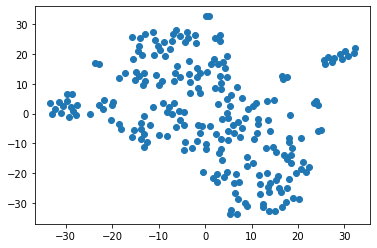

In [47]:
# calculate our model using the Word2Vec
model = Word2Vec(tweets, workers=4, size=100, min_count=50, window=10, sample=1e-3)

# print the most similar results to hurrican for checking if our model works
print(model.wv.most_similar('hurrican'))

X = model.wv[model.wv.vocab]

# calculate the TSNE
tsne = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
X_tsne = tsne.fit_transform(X)

# plot the scatter plot with the results
plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
plt.show()